![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

In [22]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data
  
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 1):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 1):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = False):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters 

### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1DNEiLAWguswhiLXGyVKsgHIRm1xZggt_'
metadata_url         = 'https://drive.google.com/uc?id=1MW3_FU6qc0qT_uG4bzxhtEHy4Jd6dCWb'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
gdown.download(image_data_url, './image_data.npy', True)
gdown.download(metadata_url, './metadata.csv', True)

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Milestone 1: Putting our model into practice

## Activity 1a: Testing on Field Data
#### While your models may have done well on your original training and validation data, deploying the model on "field" data can present different challenges. Field data is data that is different from the one where you built your model. For e.g. images obtained from a different x-ray machine.

### Exercise (Coding)

Yesterday we worked with CNNs, which we saw perform much better than multi-layer perceptrons on imaging data. 

Re-train a CNNClassifier with 5 hidden layers.

In [25]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

classifier = CNNClassifier (5)
classifier.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

### END CODE

Train on 2000 samples, validate on 400 samples
Epoch 1/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.6833 - accuracy: 0.6135 - val_loss: 0.6726 - val_accuracy: 0.8150
Epoch 2/20
 832/2000 [===========>..................] - ETA: 0s - loss: 0.6629 - accuracy: 0.7272

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2000/2000 [==============================] - 0s 245us/step - loss: 0.6476 - accuracy: 0.7425 - val_loss: 0.6289 - val_accuracy: 0.8000
Epoch 3/20
2000/2000 [==============================] - 1s 252us/step - loss: 0.5716 - accuracy: 0.8260 - val_loss: 0.5432 - val_accuracy: 0.7900
Epoch 4/20
2000/2000 [==============================] - 1s 258us/step - loss: 0.4532 - accuracy: 0.8620 - val_loss: 0.4447 - val_accuracy: 0.8325
Epoch 5/20
2000/2000 [==============================] - 0s 230us/step - loss: 0.3558 - accuracy: 0.8940 - val_loss: 0.3683 - val_accuracy: 0.8575
Epoch 6/20
2000/2000 [==============================] - 0s 221us/step - loss: 0.3022 - accuracy: 0.8925 - val_loss: 0.3760 - val_accuracy: 0.8400
Epoch 7/20
2000/2000 [==============================] - 0s 223us/step - loss: 0.2715 - accuracy: 0.9000 - val_loss: 0.4250 - val_accuracy: 0.8025
Epoch 8/20
2000/2000 [==============================] - 0s 219us/step - loss: 0.2420 - accuracy: 0.9080 - val_loss: 0.2946 - val_accura

### Exercise (Coding)

Our radiologist friends have provided some data from the field. We can access this with
```
field_data, field_labels = get_field_data()
```

Use `cnn.predict_classes(field_data)` to get your predictions. 

**Calculate: How well does our `cnn` model do on the field data?**

**IMPORTANT: Re-train your model on the field data 5 times and print the average accuracy over the 5 runs.**

In [31]:
### YOUR CODE HERE
field_data, field_labels = get_field_data()

### END CODE

average_accuracy = 0.0
for i in range(5):
  classifier = CNNClassifier(5)
  classifier.fit(field_data, field_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
  predictions = classifier.predict_classes(field_data)
  accuracy = accuracy_score(field_labels, predictions)
  
  # Train CNN and record accuracy for this run.
  ### YOUR CODE HERE
#cnn_old.predict_classes(field_data)
#print(average_accuracy)
  ### END CODE
  
average_accuracy += accuracy / 5.0
print('Average accuracy: ', average_accuracy)


### END CODE

Train on 400 samples, validate on 400 samples
Epoch 1/20
400/400 [==============================] - 0s 898us/step - loss: 0.6927 - accuracy: 0.5175 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 2/20
400/400 [==============================] - 0s 398us/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 3/20
 32/400 [=>............................] - ETA: 0s - loss: 0.6851 - accuracy: 0.5625

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


400/400 [==============================] - 0s 365us/step - loss: 0.6874 - accuracy: 0.5650 - val_loss: 0.6845 - val_accuracy: 0.5025
Epoch 4/20
400/400 [==============================] - 0s 335us/step - loss: 0.6866 - accuracy: 0.5325 - val_loss: 0.6823 - val_accuracy: 0.6700
Epoch 5/20
400/400 [==============================] - 0s 331us/step - loss: 0.6832 - accuracy: 0.5800 - val_loss: 0.6792 - val_accuracy: 0.7475
Epoch 6/20
400/400 [==============================] - 0s 352us/step - loss: 0.6799 - accuracy: 0.6750 - val_loss: 0.6741 - val_accuracy: 0.5050
Epoch 7/20
400/400 [==============================] - 0s 352us/step - loss: 0.6768 - accuracy: 0.6375 - val_loss: 0.6696 - val_accuracy: 0.5000
Epoch 8/20
400/400 [==============================] - 0s 322us/step - loss: 0.6736 - accuracy: 0.6000 - val_loss: 0.6660 - val_accuracy: 0.8100
Epoch 9/20
400/400 [==============================] - 0s 336us/step - loss: 0.6662 - accuracy: 0.6950 - val_loss: 0.6553 - val_accuracy: 0.6025
Epo

## Activity 1b: Understanding our model's performance on field data

### Exercise (Discussion)
Discuss this with your instructor:
* How did your model do? Did it perform quite as well?
* Why do you think it did this way? 
* **Come up with a few hypotheses for what's different between our test data and our field data!**

## Activity 1c: Error analysis

### Understanding where the model did not perform as well

### Exercise (Coding)

You can use the function `get_misclassified_data` to find the data where our labels are misclassifed. To use this function...


```
[missed_data, missed_labels, predicted_labels, missed_indices] = get_misclassified_data(data, labels, predictions)
```

where

* `missed_data`: the images that our model misclassified
* `missed_labels`: the labels corresponding to those images
* `predicted_labels`: what the model thought the labels were
* `missed_indices`: where in our original dataset these images were


Step 1: Use `get_misclassified_data` to get the misclassified images.

Step 2: Use `plot_one_image(data, labels, index)` to visualize them. Hint: a for loop could help you visualize many such images!


Label: 1.0


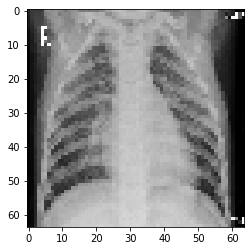

Label: 1.0


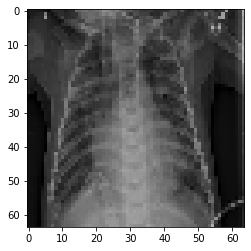

Label: 1.0


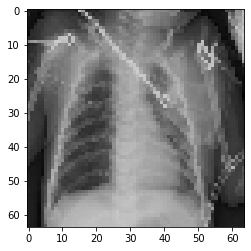

Label: 1.0


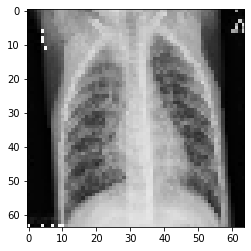

Label: 1.0


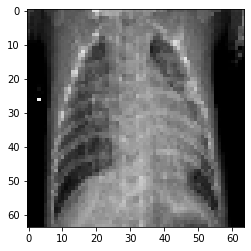

Label: 1.0


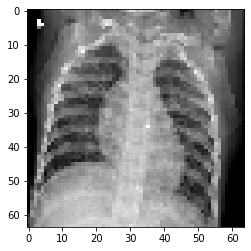

Label: 1.0


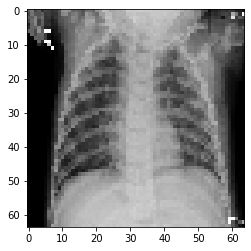

Label: 1.0


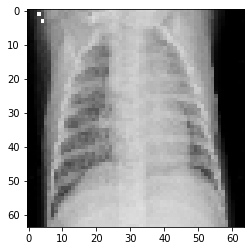

Label: 1.0


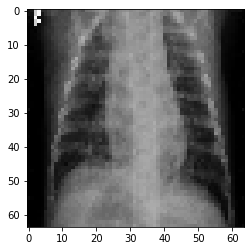

Label: 1.0


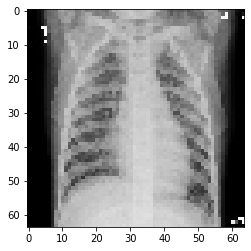

Label: 1.0


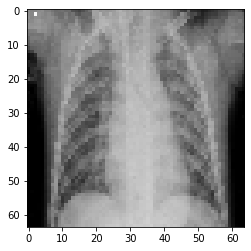

Label: 1.0


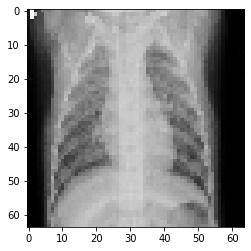

Label: 1.0


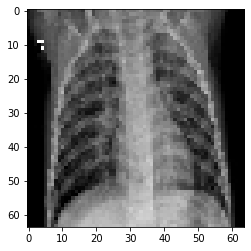

Label: 1.0


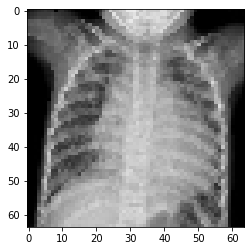

Label: 1.0


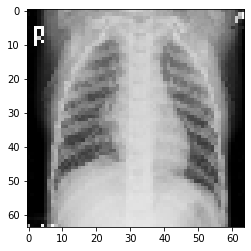

Label: 1.0


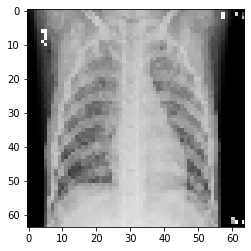

Label: 1.0


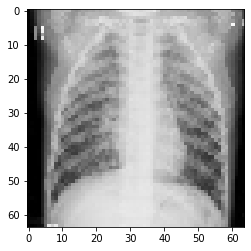

Label: 1.0


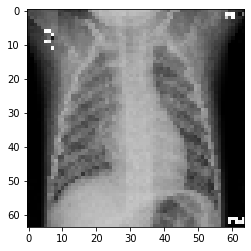

Label: 1.0


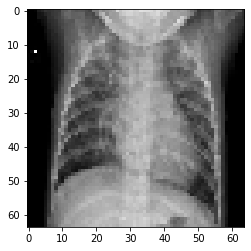

Label: 1.0


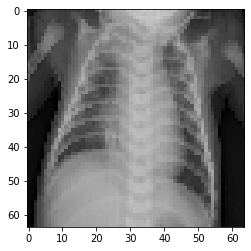

Label: 1.0


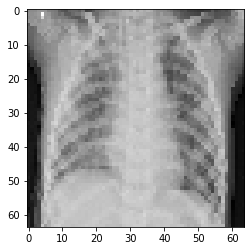

Label: 1.0


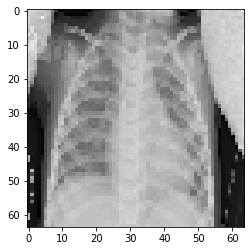

Label: 1.0


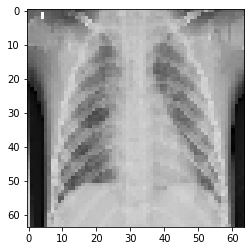

Label: 1.0


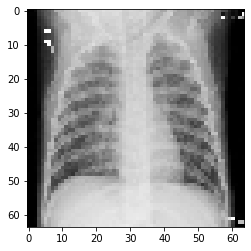

Label: 1.0


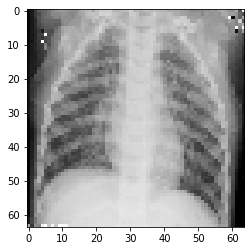

Label: 0.0


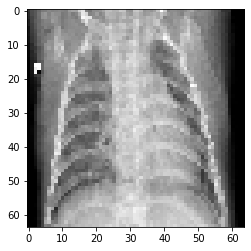

Label: 1.0


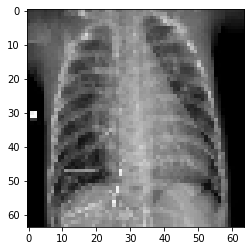

Label: 0.0


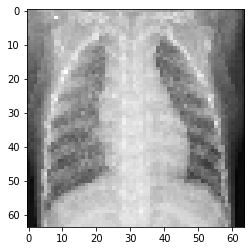

Label: 0.0


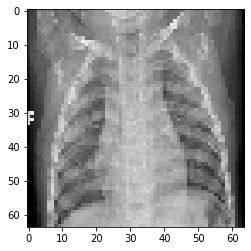

Label: 0.0


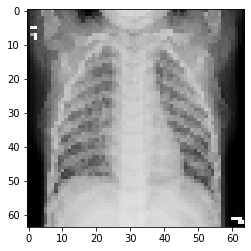

Label: 1.0


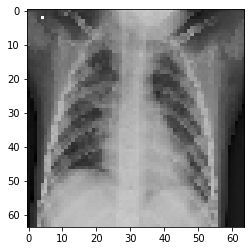

Label: 0.0


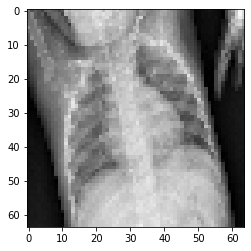

Label: 0.0


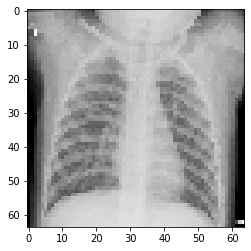

Label: 1.0


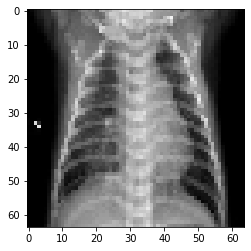

Label: 0.0


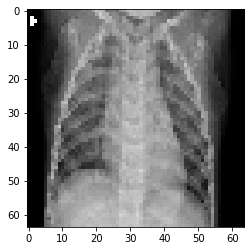

Label: 1.0


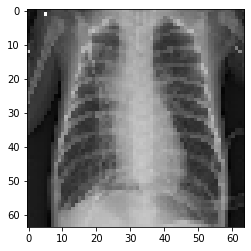

Label: 0.0


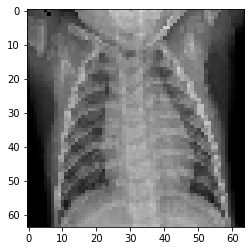

Label: 0.0


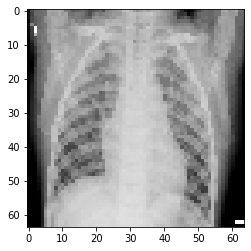

Label: 0.0


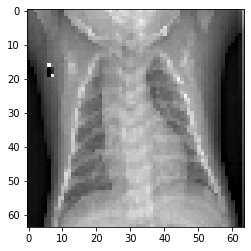

Label: 1.0


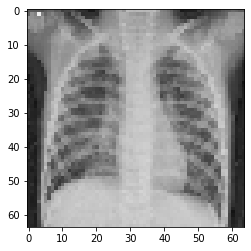

Label: 0.0


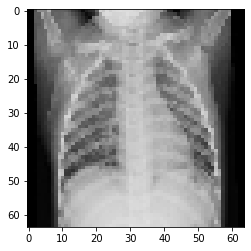

Label: 0.0


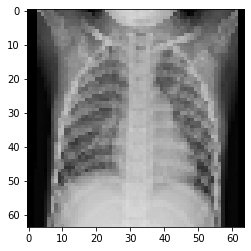

Label: 0.0


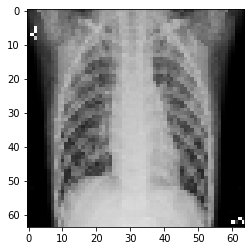

Label: 1.0


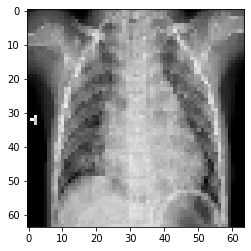

Label: 1.0


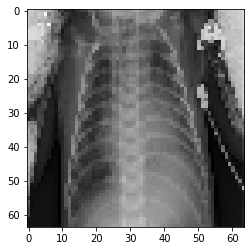

Label: 0.0


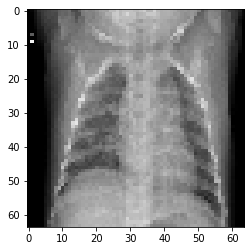

Label: 0.0


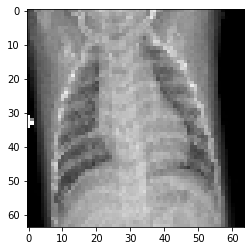

Label: 1.0


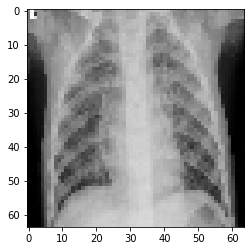

Label: 0.0


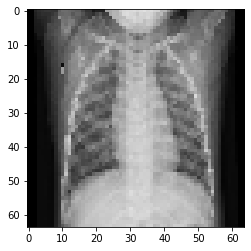

Label: 0.0


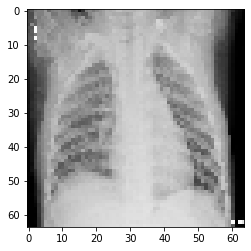

Label: 1.0


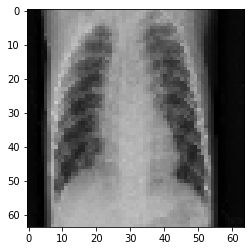

Label: 0.0


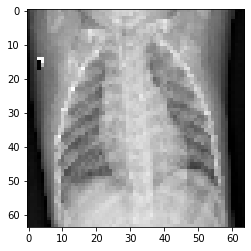

Label: 0.0


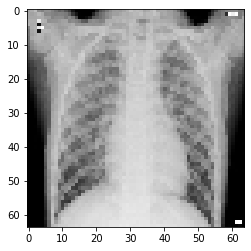

Label: 0.0


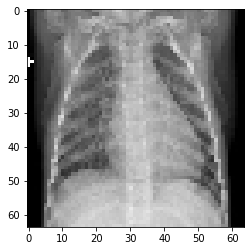

Label: 0.0


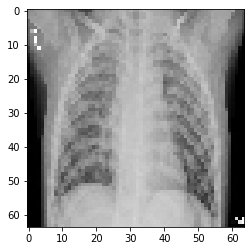

Label: 0.0


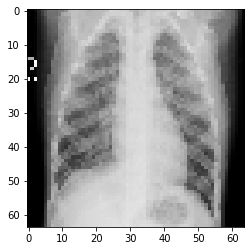

Label: 1.0


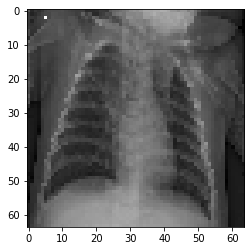

Label: 1.0


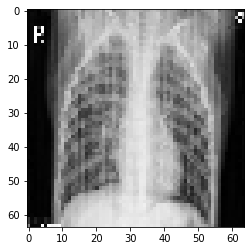

Label: 0.0


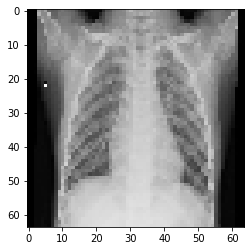

Label: 0.0


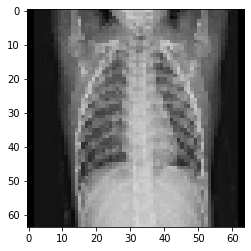

Label: 0.0


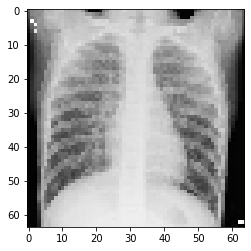

Label: 1.0


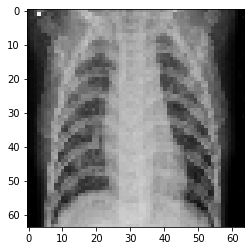

Label: 1.0


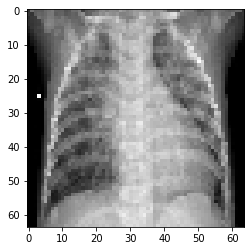

Label: 0.0


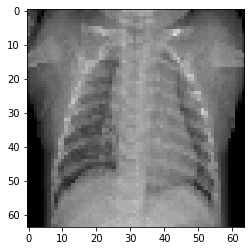

Label: 0.0


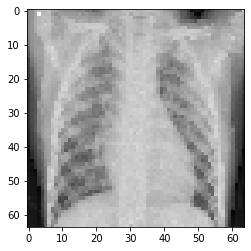

Label: 0.0


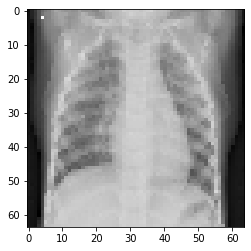

Label: 0.0


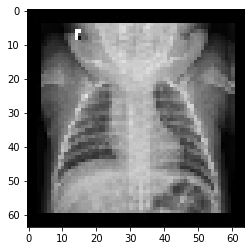

[  1   7  17  19  21  26  42  43  44  46  47  48  49  52  55  61  68  72
  73  74  83  85  87  92  97 100 119 124 141 164 165 167 170 177 182 188
 191 193 196 209 211 215 222 237 256 268 272 280 283 285 287 289 303 305
 319 327 329 330 337 340 341 347 353 373 378 379 386]


In [37]:
### YOUR CODE HERE
### Get the misclassified data 
[missed_data, missed_labels, predicted_labels, missed_indices] = get_misclassified_data(test_data, test_labels, predictions)

### Viusialize the images 
for i in range (len(missed_data)):
  plot_one_image(missed_data, missed_labels, index= i)
### END CODE
print(missed_indices)

## Instructor-Led Discussion: What is happening in our field data? 

Discuss in your group and with your instructor!

Why is our model performance suffering?

# Milestone 2: Tools to improve your models

## Activity 2a

### Instructor-Led Discussion: Data Augmentation
#### To improve the variability in our training data, we sometimes make smart alterations of our data and add to the training dataset, so that we can improve our model's performance on such 'field' datasets.

### Exercise (Coding) 

So, how do we augment our images in Python? 


We provide custom functions for augmenting a single image. 
* `rotate(image, rotate = [0, 30])`
* `scale(image, scale = [1, 1.5])`
* `shear(image, shear = [0 20])`
* `flip_left_right(image, prob = 0.5)`
* `flip_up_down(image, prob = 0.5)`
* `remove_color(data, channel = 0)`


Below, we show you how to use rotate on a single image! Try some of these options out yourself and augment your dataset with the augmenters. 

**Share some of your cool augmentation strategies with the class! You can definitely use multiple augmentation techniques for each image!**

Label: 


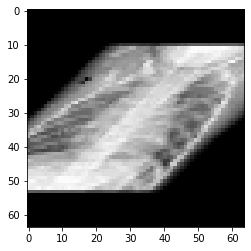

In [39]:
### YOUR CODE HERE


## This loads in an image from the training data.
## The data is of shape (num_images, width, height, color_channels).
## In order to get a different image, change the variable below.
IMAGE_INDEX = 0
image = train_data[IMAGE_INDEX,:,:,:]

## Now run some augmentations on the image and use plot_one_image to visualize them.
plot_one_image(shear(image, shear= 48))

### END CODE

## Activity 2b. 

### Exercise (Coding)

We want to add our own custom augmentations to our training data. Below, you should:
* Define a set of augmentations to do on your training data
* Augment a subset (or all) of the training data with these augmentations
* Combine the augmented data with your train data to make a new data set


To combine your original train data with your augmented data, you can use the `combine_data` function like:
```
all_data, all_labels = combine_data([data1, data2], [labels1, labels2])
```

Label: 


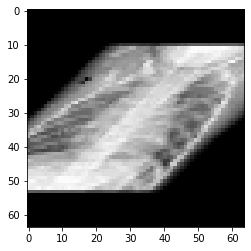

In [43]:
### YOUR CODE HERE


### Perform an augmentation.
train_data_rotated = rotate(train_data, rotate=90)
train_data_rotated_150 = rotate(train_data, rotate=150)
train_data_rotated_190 = rotate(train_data, rotate=190)

### TODO: Perform one or more additional augmentations.
plot_one_image(shear(image, shear= 48))


## Combine data. TODO: Add more data and corresponding labels here!
all_data, all_labels = combine_data([train_data, train_data_rotated, train_data_rotated_150, train_data_rotated_190], \
                                    [train_labels, train_labels])



### END CODE

Once you've created your augmented data...
1. Train your CNN on `all_data` 
2. Choose the best epoch based on the `test_data`! 
3. Load your model up and score it on `field_data`. 

**Your challenge is to find a set of augmentations that improves your model's performance on the `field_data`! Share your augmentations and performances with the class! Try as many or as few augmentations as you want.**

**Remember to record an average of 5 newly initialized CNNs. This is important because CNN weights will be initialized differently in each run!**

In [ ]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
field_data, field_labels = get_field_data()
### END CODE

average_accuracy = 0.0

for i in range(5):
  cnn = CNNClassifier(5) 
  cnn.fit(all_data, all_labels, epochs = 20, validation_data = (test_data, test_labels), suffle = True, callbacks = [monitor])
  predictions = cnn.predict_classes(all_data)
  average_accuracy /= 5.0

  ### YOUR CODE HERE

  ### END CODE

print('Average accuracy: ', average_accuracy)

### END CODE

## Instructor-Led Discussion: Why does data augmentation improve average performance?

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)